## **In this homework, you can only use numpy! No Pytorch, no mxnet, no "autograd" of any kind. You must compute gradients yourself and implement all optimizers yourself from scratch.**

# Problem 1

Consider the following function:
$$f(x, y) = x^2 + 10y^2$$
A [contour plot](https://en.wikipedia.org/wiki/Contour_line) of this function is shown below.

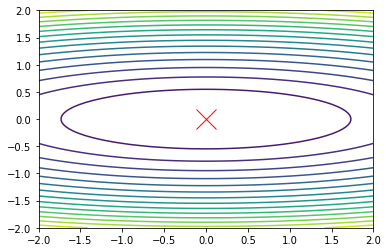

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_contour():
    x, y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
    plt.contour(x, y, x**2 + 10*y**2, levels=15)
    plt.plot(0, 0, 'rx', ms=20) 
plot_contour()

As you can see, the minimum is at (0, 0), and the curve is much steeper in the y direction than in the x direction.

1. Minimize this function using gradient descent. Use the initial point $x = 2, y = 1$. Find one learning rate where optimization diverges and one "good" learning rate that reaches the minimum in at most 20 iterations. For your solution, you should plot the steps taken by your optimizer on top of the contour plot. If you have an array `x` and another `y` which represent the x and y values followed over the course of minimization, you can plot them on top of the contor plot by doing
```Python
plot_contour()
plt.plot(x, y, '-')
```

1. Show (via derivation through calculus, not through coding) that minimizing this function using [Newton's Method](http://d2l.ai/chapter_optimization/gd.html#newton-s-method) will converge to the minimum in a single step.

1. Minimize this function using the momentum optimizer. Set the momentum hyperparameter to $0.9$. Can you find a learning rate that allows momentum to converge in less than 20 steps? Now, try optimizing for 100 steps. What is the largest and smallest learning rate you can use when optimizing for 100 steps and still converge near the minumum?

1. Implement the Adam optimizer. Use the standard values for all hyperparameters $\beta_1 = 0.9, \beta_2 = 0.999, \epsilon = 10^{-6}, \eta = 0.001$. How many steps does it take for Adam to converge with these hyperparameters? Now, change $\eta$ to the largest value you found that worked for Momentum with 100 steps. Does Adam converge in 100 steps with this value of $\eta$?

### 1.1 Minimize the function using gradient descent

$$ f(x,y) = x^2 + 10y^2 $$

$$ \frac{\partial f}{\partial x} = 2x $$
$$ \frac{\partial f}{\partial y} = 20y $$

In [2]:
def q1_func(state):
    x = state[0]; y = state[1]
    return x**2 + 10*y**2

def q1_grad(state):
    x = state[0]; y = state[1]
    dfdx = 2*x
    dfdy = 20*y
    return (dfdx, dfdy)

In [3]:
class Optimizer:
    """Implements the functionality of an arbitrary function
    optimizer class for gradient based optimization. Includes operation for the history of the
    optimization.

    def __init__(
        self,
        ic,
        lr,
        obj_fxn,
        grad_fxn,
        max_iters,
        eps
    ):

        self.history = [ic] # Instantiate the history with the initial condition
        self.n_dims = len(ic) # Get the number of dimensinos of the obj function
        self.objective_fn = obj_fxn # Specify the objective function
        self.grad = grad_fxn # Gradient function 
        self.eta = lr # Learning rate
        self.eps = eps # Convergence delta between previous iteration
        self.max_iters = max_iters # Maximum number of iterations to run optimization
        self.nits = 0 # Number of iterations

    #def step(self):
    #    return step

    def evaluate(self, x):
        return self.objective_fn(x) # Return the function evaluation  

    def minimize(self):
        delta = 9999999
        if type(self.max_iters) == int:
            for i in range(self.max_iters):
                self.step()
            print("Model converged to {} in {} iterations".format(self.history[-1], self.nits))
        else:
            while delta > self.eps:
                self.step()
                delta = np.linalg.norm(np.subtract(self.history[-2], self.history[-1]))
            print("Model converged to steps of less than {} in {} iterations".format(self.eps, self.nits))

In [50]:
class GD(Optimizer):
    """
    Implements the functionality of Gradient Descent 
    algorithm. Inherits from the optimizer class. Implements step()
    """
    def __init__(
        self,
        ic,
        lr,
        obj_fxn,
        grad_fxn,
        max_iters = None,
        eps = .0001
    ):
        super().__init__(ic, lr, obj_fxn, grad_fxn, max_iters, eps)
        
        
    def step(self):
        grads = self.grad(self.history[-1])
        updates = np.zeros(self.n_dims) #Container for holding updated state + gradients 
        for p in range(len(grads)):
            updates[p] = self.history[-1][p] - self.eta*grads[p] #Learning update rule
        self.history += [tuple(updates)]
        self.nits += 1

#### Converging Learning Rate

In [84]:
opt = GD((2,1), .089, q1_func, q1_grad)
opt.minimize()

Model converged to steps of less than 0.0001 in 44 iterations


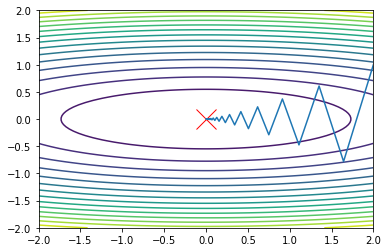

In [85]:
x, y = zip(*opt.history)
plot_contour()
plt.plot(x, y, '-')

**Note**: Although the optimization gets to the point (.039, .0069) within 20 steps, my conditions for model convergence were set to when the gradients of the objective function have an L2-norm of less than .0001.

In [96]:
opt.history[20]

(0.03967037871133182, 0.006948515870862142)

#### Diverging Learning Rate

In [11]:
opt2 = GD((2,1), .1, q1_func, q1_grad)

In [12]:
opt2.minimize() # Times out does not converge

KeyboardInterrupt: ignored

In [13]:
opt3 = GD((2,1), .5, q1_func, q1_grad) # Learning rate results in overflow

In [14]:
opt3.minimize()

Model converged to steps of less than 0.01 in 324 iterations


<ipython-input-2-2c36b06d77c2>:8: RuntimeWarning: overflow encountered in double_scalars
  dfdy = 20*y
<ipython-input-4-bff2025dd16a>:22: RuntimeWarning: invalid value encountered in double_scalars
  updates[p] = self.history[-1][p] - self.eta*grads[p] #Learning update rule


In [15]:
x3, y3 = zip(*opt3.history)

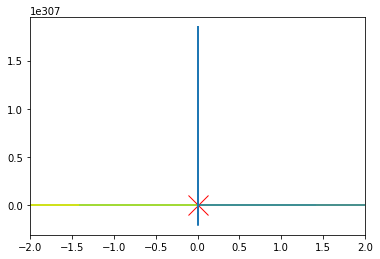

In [16]:
plot_contour()
plt.plot(x3, y3, '-')

### 1.2 One-Step Convergence with Newton's Method

$$ \nabla f(x) + \mathbf{H}\epsilon = 0 $$

$$ \mathbf{H_{f(x,y)}} = \left[\begin{array}{cc} 
\frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y}\\
\frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2}
\end{array}\right]
$$

$$ \frac{\partial^2 f}{\partial x^2} = 2 $$
$$ \frac{\partial^2 f}{\partial y^2} = 20 $$
$$ \frac{\partial^2 f}{\partial y \partial x} = \frac{\partial^2 f}{\partial x \partial y} = 0$$

$$ \mathbf{H_{f(x,y)}} = \left[\begin{array}{cc} 
2 & 0\\
0 & 20
\end{array}\right]
$$

$$ \mathbf{H_{f(x,y)}^{-1}} = \frac{1}{40}\left[\begin{array}{cc} 
20 & 0\\
0 & 2
\end{array}\right] = \left[\begin{array}{cc} 
\frac{1}{2} & 0\\
0 & \frac{1}{20}
\end{array}\right]
$$

$$ \epsilon = -\mathbf{H}^{-1} \nabla f(x,y) $$
$$ = - \left[\begin{array}{cc} 
\frac{1}{2} & 0\\
0 & \frac{1}{20}
\end{array}\right] \left[\begin{array}{cc} 
2*x \\
 20*y
\end{array}\right] 
$$

$$
= - \left[\begin{array}{cc} 
\frac{1}{2} & 0\\
0 & \frac{1}{20}
\end{array}\right]
\left[\begin{array}{cc} 
2*1 \\
 20*1
\end{array}\right]  $$

$$ \epsilon = \left[\begin{array}{cc} 
  -2 \\
 -1
\end{array}\right]
$$

$$ f(x + \epsilon_x, y + \epsilon_y) = f(2+ -2, 1 + -1) = f(0,0) $$



In [35]:
class Momentum(Optimizer):
    """
    Implements the functionality of Momentum 
    algorithm.
    """
    def __init__(
        self,
        ic,
        lr,
        momentum,
        obj_fxn,
        grad_fxn,
        max_iters = None,
        eps = .001
    ):
        super().__init__(ic, lr, obj_fxn, grad_fxn, max_iters, eps)
        self.beta = momentum 
        self.vt = np.zeros(self.n_dims) # Initialize velocity to 0

    def step(self):
        grads = self.grad(self.history[-1])
        vt = self.beta * self.vt + grads
        updates = self.history[-1] - self.eta*vt
        self.vt = vt
        self.history += [tuple(updates)]
        self.nits += 1

In [143]:
mom = Momentum((2,1), .00195, .9, q1_func, q1_grad) # Best learning rate in terms of N_its .00195
mom.minimize()

Model converged to steps of less than 0.001 in 80 iterations


For the momentum optimizer, I wasn't able to find a learning rate that caused the model to converge within 20 steps. I would have expected to find that the range of convergence for the learning rate to be greater for momentum because the momentum can act as a dampening due to the "moving average". Unsure if this was true. I think that the learning rate that would minimize the number of steps would be one that causes the model to not oscillate back and forth but rather monotonically decrease with sufficient initial push will give the least number of iterations.

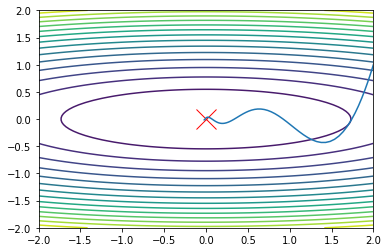

In [144]:
x, y = zip(*mom.history)
plot_contour()
plt.plot(x, y, '-')

It looks like while the optimizer did not take a monotonically decreasing path, it had very few changes in trajectory and this coupled with the large step sizes may have resulted in the lowest number of iterations I tried.

In [113]:
# Momentum for 100 Iterations

mom100 = Momentum((2,1), .00295, .9, q1_func, q1_grad, max_iters=100) 
mom100.minimize()

Model converged to (0.0059260683297301525, 0.00365748013645083) in 100 iterations


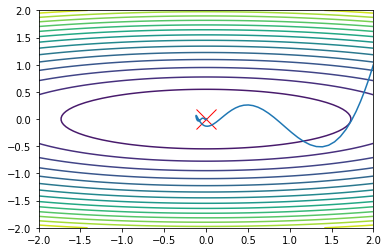

In [114]:
x, y = zip(*mom100.history)95
plot_contour()
plt.plot(x, y, '-')

In [86]:
# Qualitative Maximum LR for convergence near the known minimum 

mom100_max = Momentum((2,1), .175, .9, q1_func, q1_grad, max_iters=100) 
mom100_max.minimize()

Model converged to (0.004482826912534119, 0.00840737579864084) in 100 iterations


In [145]:
# Qualitative Minimum LR for convergence near the known minimum 

mom100_min = Momentum((2,1), .0025, .9, q1_func, q1_grad, max_iters=100) 
mom100_min.minimize()

Model converged to (-0.00705015302817979, -0.004984623110465317) in 100 iterations


In [7]:
class Adam(Optimizer):
    """
    Implements the functionality of ADAM 
    algorithm. 
    """
    
    def __init__(
        self,
        ic,
        lr,
        b1,
        b2,
        obj_fxn,
        grad_fxn,
        max_iters = None,
        eps = .0001
    ):
        super().__init__(ic, lr, obj_fxn, grad_fxn, max_iters, eps)
        self.vt = np.zeros(self.n_dims, dtype='float') # Initialize velocity to 0
        self.st = np.zeros(self.n_dims, dtype='float') # Initialize s to 0
        self.beta1 = b1
        self.beta2 = b2 # Parameter

    def step(self):

        # Calculate the gradients
        grads = self.grad(self.history[-1])

        # Calculate the state variables
        vt = self.beta1 * self.vt + np.multiply((1-self.beta1),grads)
        st = self.beta2 * self.st + (1-self.beta2)*np.square(grads)
        
        v_hat = vt/(1-self.beta1**(self.nits+1))
        s_hat = st/(1-self.beta2**(self.nits+1))

        g_prime = self.eta * v_hat / (np.sqrt(s_hat) + 1e-6)

        # Save the updated state variable
        updates = self.history[-1] - g_prime
        
        # Update state variables
        self.vt = vt
        self.st = st

        # Update history
        self.history += [tuple(updates)]
        self.nits += 1

In [94]:
adm = Adam((2,1), .25, .9, .999, q1_func, q1_grad) # Minimum LR with result close to the min
adm.minimize()

Model converged to steps of less than 0.0001 in 151 iterations


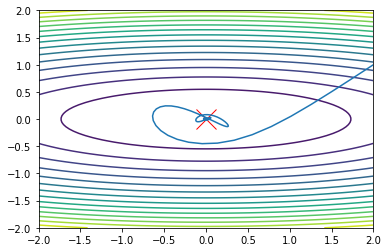

In [95]:
x, y = zip(*adm.history)
plot_contour()
plt.plot(x, y, '-')

# Problem 2

Now, consider minimization of the ["three-hump camel function"](https://www.sfu.ca/~ssurjano/camel3.html):

$$f(x, y) = 2x^2 - 1.05x^4 + \frac{x^6}{6} + xy + y^2$$

This function also has a minimum at $(0, 0)$. Below is a contour plot.

In [10]:
def q2_func(state):
    x = state[0]; y = state[1]
    return 2*x**2 - 1.05*x**4 + 1/6*x**2 + x*y + y**2

def q2_grad(state):
    x = state[0]; y = state[1]
    dfdx = 4*x -4*1.05*x**3 + x**5 + y
    dfdy = x + 2*y
    return (dfdx, dfdy)

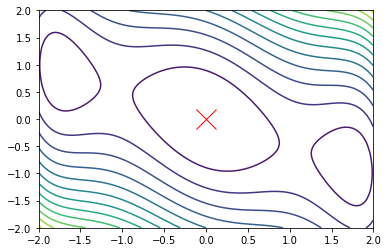

In [11]:
def plot_contour():
    x, y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
    plt.contour(x, y, 2*x**2 - 1.05*x**4 + x**6/6 + x*y + y**2, levels=15)
    plt.plot(0, 0, 'rx', ms=20) 
plot_contour()

As in the first problem, assume that optimization starts from $x = 2, y = 1$. Try minimizing it with SGD, Adam, and Momentum, while only changing the learning rate for each (not the momentum or other hyperparameters). Try to find an optimizer and learning rate that can reach the **global** minimum in as few steps as possible.

#### Gradient Descent Optimization

In [13]:
gd2 = GD((2,1), .175, q2_func, q2_grad)
gd2.minimize()

Model converged to steps of less than 0.01 in 7 iterations


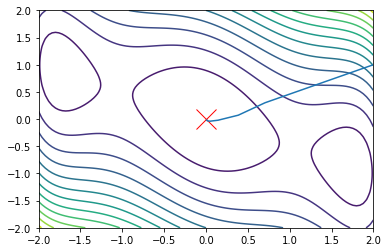

In [14]:
x, y = zip(*gd2.history)
plot_contour()
plt.plot(x, y, '-')

#### Gradient Descent Optimization w/ Momentum

In [36]:
mom2 = Momentum((2,1), .0175, .9, q2_func, q2_grad)
mom2.minimize()

Model converged to steps of less than 0.001 in 105 iterations


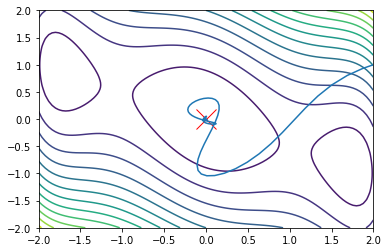

In [37]:
x, y = zip(*mom2.history)
plot_contour()
plt.plot(x, y, '-')

#### ADAM Optimization

In [29]:
adm2 = Adam((2,1), .25, .9, .999, q2_func, q2_grad) 
adm2.minimize()

Model converged to steps of less than 0.0001 in 136 iterations


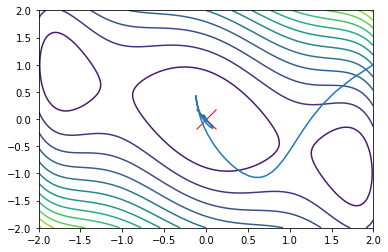

In [30]:
x, y = zip(*adm2.history)
plot_contour()
plt.plot(x, y, '-')